In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
f_sizes = "../data/reference/hg19/hg19_refseq_wo_version.sizes"
f_annotations = "../data/metadata/annotations/hg19/five_three_prime_hg19_to_refseq.txt"
f_coding = "../data/metadata/mapping/annotations_human.txt"
f_riboseq = "../translation/HepG2_RiboSeq_rpkm.txt"

f_span_vivo = "../analysis/arsenite_dge/G1_kethoxal-K562_M15_B01_span.txt"
f_span_arse = "../analysis/arsenite_dge/G1_kethoxal-K562-Arsenite-Total_M18_B01_span.txt"

f_up = "../analysis/arsenite_dge/uniq_transcripts_up_vivo_gname.txt"
f_dw = "../analysis/arsenite_dge/uniq_transcripts_dw_arsenite_gname.txt"

In [3]:
df_sizes = pd.read_csv(f_sizes, sep="\t", names=["iid", "length"])
df_annotations = pd.read_csv(f_annotations, sep="\t", names=["iid", "start", "tss", "tes", "end"])
df_coding = pd.read_csv(f_coding, sep="\t", names=["gname", "coding"])
df_riboseq = pd.read_csv(f_riboseq, sep="\t", names=["iid", "l2fc"], usecols=[0, 10])

df_span_vivo = pd.read_csv(f_span_vivo, sep="\t", names=["iid", "span_vivo"], usecols=[0, 5])
df_span_arse = pd.read_csv(f_span_arse, sep="\t", names=["iid", "span_arse"], usecols=[0, 5])
df_span_mean_vivo = df_span_vivo.groupby("iid").mean().reset_index()
df_span_mean_arse = df_span_arse.groupby("iid").mean().reset_index()

# load
df_up = pd.read_csv(f_up, sep="\t", names=["iid", "gname"])
df_dw = pd.read_csv(f_dw, sep="\t", names=["iid", "gname"])

df_up_merge = pd.merge(df_up, df_annotations, how="inner", on="iid")
df_dw_merge = pd.merge(df_dw, df_annotations, how="inner", on="iid")

# merge sizes
df_up_merge_coding = pd.merge(df_up_merge, df_coding, how="inner", on="gname")
df_dw_merge_coding = pd.merge(df_dw_merge, df_coding, how="inner", on="gname")

df_up_merge_coding_size = pd.merge(df_up_merge_coding, df_sizes, how="inner", on="iid")
df_dw_merge_coding_size = pd.merge(df_dw_merge_coding, df_sizes, how="inner", on="iid")

df_up_merge_coding_size_riboseq = pd.merge(df_up_merge_coding_size, df_riboseq, how="inner", on="iid")
df_dw_merge_coding_size_riboseq = pd.merge(df_dw_merge_coding_size, df_riboseq, how="inner", on="iid")

df_up_merge_coding_size_riboseq = df_up_merge_coding_size_riboseq[df_up_merge_coding_size_riboseq.gname!="NEAT1"]
df_dw_merge_coding_size_riboseq = df_dw_merge_coding_size_riboseq[df_dw_merge_coding_size_riboseq.gname!="NEAT1"]

print(df_up_merge_coding_size_riboseq.shape, df_dw_merge_coding_size_riboseq.shape)

df_up_merge_coding_size_riboseq = pd.merge(df_up_merge_coding_size_riboseq, df_span_mean_vivo, how="inner", on="iid")
df_up_merge_coding_size_riboseq = pd.merge(df_up_merge_coding_size_riboseq, df_span_mean_arse, how="inner", on="iid")

df_dw_merge_coding_size_riboseq = pd.merge(df_dw_merge_coding_size_riboseq, df_span_mean_vivo, how="inner", on="iid")
df_dw_merge_coding_size_riboseq = pd.merge(df_dw_merge_coding_size_riboseq, df_span_mean_arse, how="inner", on="iid")

df_up_merge_coding_size_riboseq["condition"] = "vivo"
df_dw_merge_coding_size_riboseq["condition"] = "arsenite"

print(df_up_merge_coding_size_riboseq.shape, df_dw_merge_coding_size_riboseq.shape)

(104, 9) (73, 9)
(104, 12) (73, 12)


In [4]:
df_results = pd.concat([df_up_merge_coding_size_riboseq, df_dw_merge_coding_size_riboseq])

In [5]:
df_results["five_utr"] = (df_results.tss-df_results.start)
df_results["cds"] = (df_results.tes-df_results.tss)
df_results["three_utr"] = (df_results.end-df_results.tes)

### Distribution By Length

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:6.019e-16 U_stat=1.110e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:4.225e-16 U_stat=9.375e+02


(230.8698193054116, 25402.384848934336)

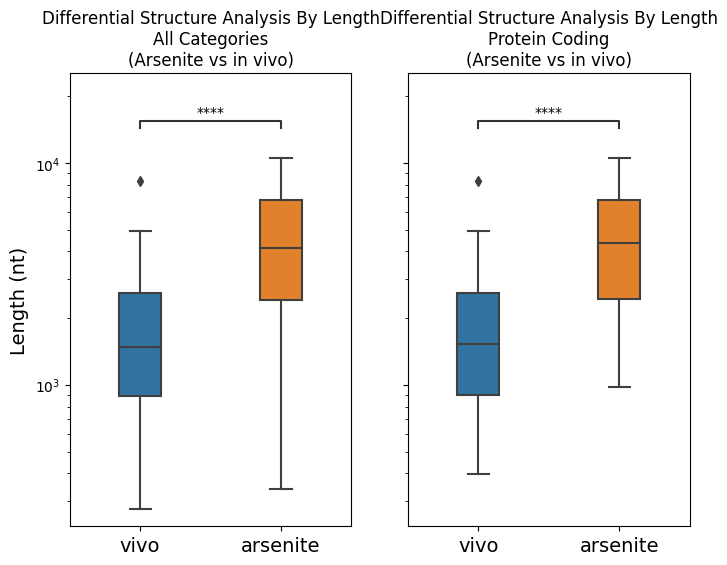

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True, dpi=100)

median_vivo = np.percentile(df_up_merge_coding_size_riboseq["length"], 50)
median_arse = np.percentile(df_dw_merge_coding_size_riboseq["length"], 50)

ax_vp = sns.boxplot(x="condition", y="length", data=df_results, ax=ax[0], width=0.3)
ax[0].set_title("Differential Structure Analysis By Length\nAll Categories\n(Arsenite vs in vivo)")
ax[0].set_xlabel(None)
ax[0].set_ylabel("Length (nt)", fontsize=14)
ax[0].set_xticklabels(["vivo", "arsenite"], fontsize=14)
#ax[0].legend()
ax_vp.set_yscale("log")

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_vp, pairs, data=df_results, x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate()
#low, high = ax_vp.get_ylim()
#ax_vp.set_ylim(low, high*1.1)

ax_vp = sns.boxplot(x="condition", y="length", data=df_results[df_results.coding=="protein_coding"], ax=ax[1], width=0.3)
ax[1].set_title("Differential Structure Analysis By Length\nProtein Coding\n(Arsenite vs in vivo)")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(["vivo", "arsenite"], fontsize=14)
#ax[1].legend()

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_vp, pairs, data=df_results[df_results.coding=="protein_coding"], x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate()
low, high = ax_vp.get_ylim()
ax_vp.set_ylim(low, high*2)

#plt.savefig("analysis_by_length.png", dpi=300)
#plt.savefig("analysis_by_length.pdf")

### Distribution by Locality

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:8.505e-15 U_stat=1.066e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:2.952e-15 U_stat=8.775e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:4.832e-16 U_stat=9.095e+02


(1, 99141.0)

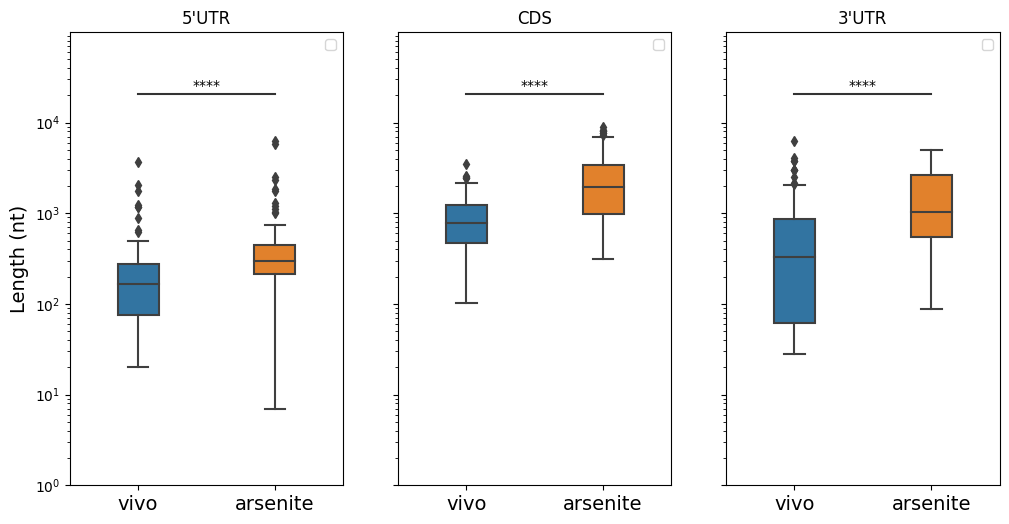

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True, dpi=100)

median_vivo = np.percentile(df_up_merge_coding_size_riboseq["length"], 50)
median_arse = np.percentile(df_dw_merge_coding_size_riboseq["length"], 50)

ax_bp = sns.boxplot(x="condition", y="five_utr", data=df_results[df_results.five_utr!=0], ax=ax[0], width=0.3)
ax[0].set_title("5'UTR")
ax[0].set_xlabel(None)
ax[0].set_ylabel("Length (nt)", fontsize=14)
ax[0].set_xticklabels(["vivo", "arsenite"], fontsize=14)
ax[0].legend()

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_bp, pairs, data=df_results[df_results.five_utr!=0], x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate(line_offset_to_group=2)

ax_bp1 = sns.boxplot(x="condition", y="cds", data=df_results[df_results.cds!=0], ax=ax[1], width=0.3)
ax[1].set_title("CDS")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(["vivo", "arsenite"], fontsize=14)
ax[1].legend()

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_bp1, pairs, data=df_results[df_results.cds!=0], x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate(line_offset_to_group=2)

ax_bp = sns.boxplot(x="condition", y="three_utr", data=df_results[df_results.three_utr!=0], ax=ax[2], width=0.3)
ax[2].set_title("3'UTR")
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].set_xticklabels(["vivo", "arsenite"], fontsize=14)
ax[2].legend()

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_bp, pairs, data=df_results[df_results.three_utr!=0], x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate(line_offset_to_group=2)

ax_bp.set_yscale("log")

low, high = ax_bp.get_ylim()
ax_bp.set_ylim(1, high*15)

#plt.savefig("analysis_by_locality.png", dpi=300)
#plt.savefig("analysis_by_locality.pdf")

### Distrbution by Translational Efficiency

No handles with labels found to put in legend.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

vivo vs. arsenite: Mann-Whitney-Wilcoxon test two-sided, P_val:4.832e-16 U_stat=9.095e+02


(-4.1608354264865195, 5.986260393911464)

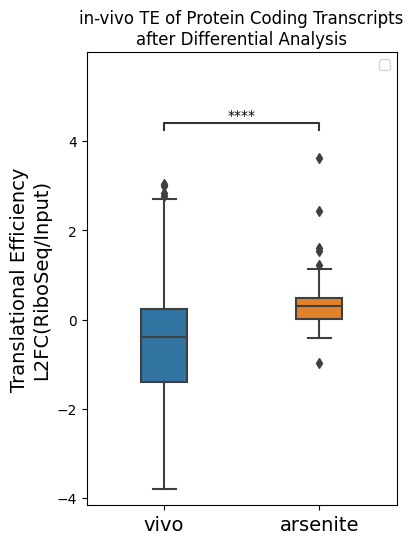

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6), sharex=True, sharey=True, dpi=100)

median_vivo = np.percentile(df_up_merge_coding_size_riboseq["length"], 50)
median_arse = np.percentile(df_dw_merge_coding_size_riboseq["length"], 50)

ax_bp = sns.boxplot(x="condition", y="l2fc", data=df_results[df_results.coding=="protein_coding"], ax=ax, width=0.3)
ax.set_title("in-vivo TE of Protein Coding Transcripts\nafter Differential Analysis")
ax.set_xlabel(None)
ax.set_ylabel("Translational Efficiency\nL2FC(RiboSeq/Input)", fontsize=14)
ax.set_xticklabels(["vivo", "arsenite"], fontsize=14)
ax.legend()

pairs = [("vivo", "arsenite")]
annotator = Annotator(ax_bp, pairs, data=df_results[df_results.three_utr!=0], x="condition", y="length")
annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.apply_test(alternative="less")
annotator.annotate()

#ax_bp.set_yscale("log")

low, high = ax_bp.get_ylim()
ax_bp.set_ylim(low, high*1.5)

#plt.savefig("analysis_by_translation_efficiency.png", dpi=300)
#plt.savefig("analysis_by_translation_efficiency.pdf")